<a href="https://colab.research.google.com/github/vincent4u/CE807_Text_Analytics/blob/main/week1/Introduction_to_Text_Analysis_in_Python_A_Hands_on_Tutorial_(SICSS_2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Hello and welcome! In this notebook I'll be leading you through an introduction to text analysis in Python. While I won't explicitly walk through the basics of Python itself, I'll try to write and comment my code such that someone with limited coding experience can follow along. You should absolutely feel free to take this code, change it however you see fit, and use it for your own projects and analyses. I'll aim cover the following:


*   Scraping tweets from the Twitter API v2
*   Downloading data from public GitHub repositories
*   Basic pre-processing and handling of text data (we'll be working specifically with data pulled from Twitter)
*   Using "dictionary" methods to analyze linguistic differences between groups that produce text
*   Using "open-vocabulary" methods (specifically differential language analysis or DLA) to analyze linguistic differences between groups that produce text
*    Creating some simple plots of results using matplotlib.pyploy and seaborn

This is by no means a comprehensive review of text analytic techniques, and the methods I cover here are neither the most foundational nor the most popular approaches to computational text analysis in social science. They are instead the most conceptually straight-forward approaches to analyzing systematic variation in the frequencies of unigrams (words). They are also, in my humble opinion, perhaps the first methods one should apply to a corpus if they don't already have a particular method in mind. This is because they are highly interpretable and transparent. Additionally, they lend themselves to a suprisingly diverse array of social scientific questions.

But first a quick note about how I write my code in this tutorial. I'm not very likely here to break my tasks into various functions, which is generally considered "bad practice". In fact, there's only a couple times in this whole tutorial where I define a function that is used inside another of my own functions. This, of course, has significant tradeoffs (e.g. debugging this notebook has been nothing short of painful), but I placed a high premium on this code being as readable and followable for folks as possible. I've always found that having to look into a function called inside of a function inside of a third function makes getting acquainted with another's code more difficult, especially when I was just beginning in my programming journey. For this same reason, my code might seem "over-commented" to many and at some points I expand what might have reasonably been a single line of code into 2-4 lines. I hope that none of this is too distracting for anyone!

## Using this notebook

This tutorial is written in a Google Colaboratory (Colab) Notebook. It's a really great tool that's available for free from Google and is basically Google Docs/Slides/Sheets for Python code. What's amazing is that even if you don't have Python downloaded on your machine, you can run this code in your browser.

Now, if you're on this page and are logged into a Google account, you should be able to run this code and see results. You won't, however, be able to save any changes you want to make to the code without first saving a copy. To do that, click on the "File" menu in the top-left of the page and use one of the various save options (the easiest is probably "Save a copy in Drive"). To run the code in a cell, either (a) hover your cursor over the cell and click on the run button that appears (shaped like a play button) or (b) click inside a cell and then type Ctrl + Enter. Results and messages from the code will appear directly below it.

## Libraries

First, we'll  import the set of libraries (bits of helpful code others have written and made available for anyone to use) we'll be relying on for our analyses.

In [ ]:
import requests
import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from collections import Counter
import re
import statsmodels.api as sm
from numpy.linalg import LinAlgError
from scipy.stats import ranksums
import time
import multiprocessing as mp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Some of these libraries are just ones I happen to like or tend to use in my code, but several of these libraries are worth mentioning by name briefly, as they are commonly used in the analysis of up to relatively large datasets in Python.
* `numpy` is a very handy library that allows for fairly quick computation over matrices and vectors.
* `pandas` is built around "dataframes", which are helpful data structures for data sets. It allows one to apply various transformations to datasets with ease and relative speed.
* `nltk` is a library with a whole bunch of tools for doing natural language processing. It's generally considered a standard in the field, though a lot of reasonable alternatives exist, including Stanza (developed by folks at Stanford) and SpaCy.
* `matplotlib.pyplot` and `seaborn` are both libraries that help with visualizing data in Python. These are definitely not the only packages one could reasonably use (e.g. Altair, Vega-Lite, and Plotly), but I find that these two libraries nicely combine ease of use, quality visualization, and intuitive customizeability.
* `statsmodel` is a library that lets you do basic econometric analyses (e.g. multiple linear regression) in Python. In my honest opinion I think this library leaves much to be desired, but I haven't found a better alternative (and am open to suggestions!).

# Section I: Using the Twitter API v2

In this section we're going to talk about the Twitter API v2. If you don't have a Twitter account and/or are not interested in learning to use the Twitter API, you should feel free to skip this section. The rest of the sections in this tutorial run completely independent of this one.

One thing I'm not going to cover here in-depth is applying for a developer account on Twitter, though you'll need one to run the code in this section. I will, however, point you to a couple of helpful resources and discuss some broad bullet points.
* Assuming you already have a Twitter account, [this page](https://developer.twitter.com/en/apply-for-access) is where you start to apply for a "developer" account, or an account that will give you access to Twitter as a data source.
* There are two "tracks" that developer accounts can now be on: "standard" and "academic research". [This page](https://developer.twitter.com/en/products/twitter-api/academic-research) lays out the differences and who is eligible for which.
* The Twitter API has various "endpoints", or different ways you can access Twitter as a data source. In this section we'll cover three of them (pulling users' timelines using the Timelines endpoint; scraping the "spritzer" steam using the Sampled Stream endpoint; and querying the full Twitter archive using the Search Tweets endpoint), but see [here](https://developer.twitter.com/en/docs/api-reference-index) for a complete list.
* Twitter limits how much data you can pull from their API. Exactly how much depends on what type of account you have and what endpoints you use, but it's worth noting this before we begin. You should therefore be smart about managing what tweets you pull, or else you'll be stuck waiting for up to a month before you can pull the data you need.


## Getting started

There are two things that you will need to provide for any request you make to the Twitter API: (1) your bearer token and (2) the pieces of information you want about each tweet you pull. Because these will be used frequently, we're just going to define them here before we start so we don't have to worry about them later.

First, you will need to copy your bearer token into the string in the cell below. Your bearer token is like another password for your developer account and is associated with a particular "project" (see the video paired with this notebook for more information); it's one way for Twitter to confirm that you're the one trying to get acces to their data. Before you insert your bearer token below, you should **be sure** that no one else can access your version of this notebook (if someone else does obtain your bearer token, you can always re-generate it in the twitter developer portal). Check out [this page](https://developer.twitter.com/en/docs/authentication/oauth-2-0/bearer-tokens#:~:text=your%20Bearer%20Token.-,Login%20to%20your%20Twitter%20account%20on%20developer.twitter.com.,Key%20and%20API%20Secret%20Key.) for more information on accessing and regenerating your bearer token (and note that since we're using the v2 API, as it says on the linked page, "you will need to make sure that the developer App is within a Project").

Then, we'll need to define the pieces of information we want about each queried tweet. Some of the possible fields include: `attachments`, `author_id`, `context_annotations`, `conversation_id`, `created_at`, `entities`, `geo`, `lang`, `possibly_sensitive`, `public_metrics`, and `text`. See the various API documentations (linked in each section's header) for a complete list and more information. We're going to ask for each tweet's text, its public metrics (e.g. retweet count and favorite count), the time at which it was published, the author's identification number, and information on the location tagged in the tweet (if it's available). Feel free to change this and see what other information you can get!

In [ ]:
bearer_token = "**************** INSERT YOUR BEARER TOKEN HERE ****************"

tweet_fields = ["text", "public_metrics", "created_at", "author_id", "geo"]

Next we'll look at calling three different endpoints of the Twitter API. For each, I'll define a function that you could easily use to pull your own data from the Twitter API and show you how to use it! I'll be aiming to create these functions such that you can (a) easily customize them for your own purposes and (b) follow along and get an understanding for how you might do this on your own "from scratch".

## Pulling the tweets of specific users

The API endpoint we explore here is the "timeline" endpoint. This endpoint allows you to pull tweets from the timeline of a specified Twitter account (or, by slightly changing this code, tweets that mention that user). For more information, check out [the API documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/introduction).

In [ ]:
def get_user_tweets(users,
                    bt=bearer_token,
                    tweet_fields = tweet_fields,
                    expansions = None,
                    expansion_fields = None,
                    start_time = None,
                    end_time = None):

  '''
  Function that takes in a list of Twitter users' IDs and pulls those users'
  tweets from the timeline endpoint of the Twitter API.

  Assumes that one's Twitter dev account bearer token is stored as a string in
  a variable called "bearer-token" and that "tweet_fields" is a list of the
  values to be passed to the API call as query parameters under "tweet.fields".

  Optionally, you can define a "start_time" and/or an "end_time" parameter,
  which will limit the tweets pulled from the users' timeline accordingly.
  These should be strings formated as "YYYY-MM-DDTHH:mm:ssZ", e.g.
  "2021-06-01T00:00:00Z" For midnight on June 1st, 2021.

  Optionally, you can also define "expansions" (list of strings), which will be
  passed to the API call, making additional information available upon request.
  To request that information, also pass a dictionary to "expansion_fields" for
  which its keys are the parameter names (e.g. "user.fields") and its values are
  a list of string indicating what fields you want to request from those
  expansions.

  Returns a list of JSON objects, which can be traversed as a list of dictionaries.
  '''

  #create a receptacle for the API's responses
  responses = []

  for user in users:

    '''
    This is the base url for the part of the timelines endpoint
    that lets one pull tweets from the user's timeline
    '''
    url = "https://api.twitter.com/2/users/{}/tweets".format(user)

    #Store one's bearer token in a way legible to the Twitter API
    header = {"Authorization": "Bearer {}".format(bt)}

    #Encode the desired tweet fields in a way legible to the Twitter API
    params = {"tweet.fields": ','.join(tweet_fields)}

    #If you passed expansions, include these in the API request
    if expansions:
      params['expansions'] = ','.join(expansions)
      for exp in expansion_fields:
        params[exp] = ','.join(expansion_fields[exp])

    #If you defined a start and/or end time, add them to the API request
    if start_time:
      params['start_time'] = start_time
    if end_time:
      params['end_time'] = end_time

    #Make the actual call to the Twitter API
    response = requests.request("GET", url, headers=header, params=params)

    #If there's an error, be sure to print it out so we know what's going on
    if response.status_code != 200:
      print("Got the following error for user {0}: {1}".format(user, response.text))

    #Add the user's tweets to our receptacle
    responses.append(response.json())

  return responses

In [ ]:
#The user IDs of my, Professor Bail's, and Professor Salginik's Twitter accounts, respectively
users = ["491278138","964635660","4509741"]

'''
Pull all the tweets published by me, Professor Bail, and Professor Salganik
from June 1st to now. Above and beyond the tweet-level information we designated
earlier, we'll also be asking for additional user-level information.
Specifically, we'll ask each user's Twitter account description.
'''
results = get_user_tweets(users, start_time="2021-06-01T00:00:01Z",
                          expansions=["author_id"],
                          expansion_fields={"user.fields": ["description"]})

A quick aside about timestamps: the Twitter API uses [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) to encode time. The "T" in the middle simply seperates the date and the time. The "Z" at the end tells you that the time is being reported with respect to Coordinated Universal Time ([UTC](https://en.wikipedia.org/wiki/Coordinated_Universal_Time))

In [ ]:
#Print the most recent tweet from my account
results[0]['data'][0]

{'author_id': '491278138',
 'created_at': '2021-06-15T16:45:48.000Z',
 'id': '1404842587219955723',
 'public_metrics': {'like_count': 0,
  'quote_count': 0,
  'reply_count': 0,
  'retweet_count': 273},
 'text': 'RT @joshuacpeterson: (1/11) Incredibly excited about our work out today in @ScienceMagazine: We show how scientific theory development can…'}

In [ ]:
#Print my user information
results[0]['includes']

{'users': [{'description': 'Sociology PhD candidate at Stanford University, studying political polarization and organizations. Lover of jazz, stand-up comedy, and the Beatles.',
   'id': '491278138',
   'name': 'Austin van Loon',
   'username': 'AustinVanLoon'}]}

In [ ]:
#Print the most recent tweet from Professor Bail's account
results[1]['data'][0]

{'author_id': '964635660',
 'created_at': '2021-06-18T15:00:00.000Z',
 'id': '1405903128461922310',
 'public_metrics': {'like_count': 18,
  'quote_count': 5,
  'reply_count': 1,
  'retweet_count': 1},
 'text': '"Recent developments in computer science and digital image processing have enabled the extraction of an individual’s heart pulsations from pixel changes in recorded video images of human skin surfaces" HT @AjuaDuker https://t.co/Sh2MeGZtxz https://t.co/0VJe5hy0FB'}

In [ ]:
#Print Professor Bail's user information
results[1]['includes']

{'users': [{'description': 'Duke Professor/Director https://t.co/oLxcnFtUMi, Author of "Breaking the Social Media Prism: How to Make our Platforms Less Polarizing" (https://t.co/QPZ92JtVxk) ✍️ NYT, CNN',
   'id': '964635660',
   'name': 'Chris Bail',
   'username': 'chris_bail'}]}

In [ ]:
#Print the most recent tweet from Professor Salganik's account
results[2]['data'][0]

{'author_id': '4509741',
 'created_at': '2021-06-16T18:36:10.000Z',
 'id': '1405232753101189121',
 'public_metrics': {'like_count': 0,
  'quote_count': 0,
  'reply_count': 0,
  'retweet_count': 33},
 'text': 'RT @chris_bail: What are the career options for computational social scientists outside academia? Join me next week to learn about this top…'}

In [ ]:
#Print Professor Salganik's user information
results[2]['includes']

{'users': [{'description': 'Prof of Sociology @Princeton, Director @PrincetonCITP, Co-founder https://t.co/WPFjHZbzrI, Author of Bit by Bit: Social Research in the Digital Age: https://t.co/cRyhE3oeaK',
   'id': '4509741',
   'name': 'Matthew Salganik',
   'username': 'msalganik'}]}

This data, while highly structured, might not be in the most useful of formats. You'll likely need to traverse this data on your own and do some manipulation of it to get it the way you need it for your research. We'll have an example of this in the next section of this tutorial.

You might notice that the text of retweets are capped. That is, if you pull a user's retweet you might not actually get all of the text of the original tweet. This can be overcome by requesting the original tweet's ID and then using [another API endpoint](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference) to look up that tweet. We won't get into that here. If you wanted to specifically not pull retweets (and/or replies), you can do so by adding an `exclude` parameter to the query (see the API documentation linked at the beginning of this section).

## Scraping tweets from the "spritzer" stream as they're published

Sometimes we might not be interested in particular users, but in tweets happening right now. We might also be interested in just getting a [random](https://www.forbes.com/sites/kalevleetaru/2019/02/27/is-twitters-spritzer-stream-really-a-nearly-perfect-1-sample-of-its-firehose/?sh=767682e75401) sample of tweets. The Twitter API makes this possible by having various "streams" of tweets that are available. The "firehose" is roughly all tweets and the "decahose" is approximately 10% of all tweets, but both of these typically require paying Twitter or having some kind of special access. Anyone with a developer account, however, can access the "spritzer", which is approximately 1% of the firehose.

Because these tweets are constantly streaming and not a static look-up like the previous API call, the code to use this endpoint is slightly more complicated. I've set up the function here so that you can either specify a number of tweets to pull from the stream *or* you can specify a length of time (in seconds) for which you'd like to be cotninually pulling from the stream.

Note that these will be sampled from *all* tweets, including tweets not from all over the world, in any number of languages, and potentially tweets authored by bots. There is another endpoint called the [filtered stream](https://developer.twitter.com/en/docs/twitter-api/tweets/filtered-stream/introduction) (as opposed to the sampled stream, which is what we use here) which allows you to only pull tweets that meet a passed query (e.g. only tweets published in the U.S. that include "#BLM"). See the [API documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/sampled-stream/introduction) for more info.

In [ ]:
def tweet_stream(url, header, params):
  '''
  A helper function that connects to the Twitter API's sampled stream endpoint.

  Returns a generator that yields tweets from the unfiltered spritzer stream.
  '''

  #Open the ongoing connection to the spritzer stream
  with requests.request("GET", url, headers=header,
                        params=params, stream=True) as response:

    #If there was an error, print it so we know what's going on
    if response.status_code != 200:
        print("Got the following error: {}".format(response.text))

    else:

      #For each tweet that gets returned...
      for response_item in response.iter_lines():
        if response_item:
          tweet = json.loads(response_item)

          #...Pass along the tweet
          if 'includes' in tweet:
            yield {**tweet['data'], **tweet['includes']}
          else:
            yield tweet['data']


def get_streaming_tweets(bt=bearer_token,
                         tweet_fields = tweet_fields,
                         expansions = None,
                         expansion_fields = None,
                         t = None,
                         n = 100):
  '''
  Function that requests tweets from the unfiltered Twitter spritzer stream.

  Assumes that one's Twitter dev account bearer token is stored as a string in
  a variable called "bearer-token".

  You can either pass t, the number of seconds you would like to pull tweets
  continuously from the stream, or n, the exact number of tweets you'd like
  to pull. By default, n is set as 100.

  Optionally, you can also define "expansions" (list of strings), which will be
  passed to the API call, making additional information available upon request.
  To request that information, also pass a dictionary to "expansion_fields" for
  which its keys are the parameter names (e.g. "user.fields") and its values are
  a list of strings indicating what fields you want to request from those
  expansions.

  Returns a list of JSON objects, which can be traversed as a list of dictionaries.
  '''

  #This is the base url for the sampled stream endpoint
  url = "https://api.twitter.com/2/tweets/sample/stream"

  #Store one's bearer token in a way legible to the Twitter API
  header = {"Authorization": "Bearer {}".format(bt)}

  #Encode the desired tweet fields in a way legible to the Twitter API
  params = {'tweet.fields': ','.join(tweet_fields)}

  #If you passed expansions, include these in the API request
  if expansions:
    params['expansions'] = ','.join(expansions)
    for exp in expansion_fields:
      params[exp] = ','.join(expansion_fields[exp])

  #Create a receptacle for the API's responses
  results = []

  #If you passed a time for which to be pulling from the spritzer continuously...
  if t:

    #Define the time at which you began connecting to the stream
    start = time.time()
    end = time.time()

    #Connect to the stream
    stream = tweet_stream(url, header, params)

    #Until time runs out, keep pulling tweets and append them to our receptacle
    while end-start < t:
      results.append(next(stream))
      end = time.time()
    stream.close()

  #If you passed a number of tweets to pull from the spritzer...
  elif n:

    #Connect to the stream
    stream = tweet_stream(url, header, params)

    '''
    Until you have the requested number of tweets,
    keep pulling one tweet and append it to our receptacle
    '''
    while len(results) < n:
      results.append(next(stream))
    stream.close()

  else:
    raise Exception("Must define either t or n")

  return results

Because we're receiving a single tweet at a time, this code actually cleans up the data we receive from the API a little more than the previous code.

In [ ]:
#Pull one second of the spritzer with no expansions
get_streaming_tweets(t=1)

[{'author_id': '2569904109',
  'created_at': '2021-06-18T17:24:06.000Z',
  'geo': {},
  'id': '1405939391432990736',
  'public_metrics': {'like_count': 0,
   'quote_count': 0,
   'reply_count': 0,
   'retweet_count': 10},
  'text': 'RT @TokenBlackYgo: Do it with the niggas you came up with 🤘🏾'}]

In [ ]:
'''
Get five tweets from the spritzer with author information and more information
on the location tagged in the tweet included if it's available
'''
get_streaming_tweets(n=5,
                     expansions=['author_id','geo.place_id'],
                     expansion_fields={'user.fields': ['description','location'],
                                       'place.fields': ['country_code',
                                                        'contained_within',
                                                        'country']})

[{'author_id': '725765102520115200',
  'created_at': '2021-06-18T17:24:09.000Z',
  'geo': {'place_id': '000799c66e428a87'},
  'id': '1405939404003328009',
  'places': [{'country': 'Kingdom of Saudi Arabia',
    'country_code': 'SA',
    'full_name': 'Jeddah, Kingdom of Saudi Arabia',
    'id': '000799c66e428a87'}],
  'public_metrics': {'like_count': 0,
   'quote_count': 0,
   'reply_count': 0,
   'retweet_count': 0},
  'text': '@alitawati وبعد 4سنوات يرجع ترامب ويلغي الاتفاق.',
  'users': [{'description': '\u200f\u200f\u200f\u200f\u200f\u200f\u200f\u200fخبره عمليه في القطاع الخاص تتجاوز 20 عام. ومؤسس شركه خبراء المهنه للأمن والسلامه. ش ذ م م. تحت التأسيس.\n\nرؤيه 2030 حلمنا الذي نراه يتحقق...',
    'id': '725765102520115200',
    'location': 'جدة, المملكة العربية السعودية',
    'name': 'khaled Alzhrani',
    'username': 'kyaz_46'},
   {'description': 'الرأي قبل شجاعة الشجعان https://t.co/zsa6DHJyhq',
    'id': '264320527',
    'location': 'Jeddah, Saudi Arabia',
    'name': 'د.علي التو

## Querying the full Twitter archive

Here we use the archive search endpoint, which lets us search through ALL tweets ever published on Twitter to find those that match a query we pass to it (see [here](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query) for information on building a query). Importantly, this API endpoint is only available for developer accounts on the academic research track (as opposed to the standard track). See the [API documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-all) for more information.

In [ ]:
def query_twitter_archive(query, n,
                          bt = bearer_token,
                          tweet_fields = tweet_fields,
                          expansions = None,
                          expansion_fields = None,
                          start_time = None,
                          end_time = None):

  '''
  Function that takes in a query and a number of desired results, requests this
  from the Twitter API's full archive search endpoint, and returns the results.

  "query" should be a string and "n" should be an integer between 10 and 500.

  Assumes that one's Twitter dev account bearer token is stored as a string in
  a variable called "bearer-token".

  Optionally, you can also define "expansions" (list of strings), which will be
  passed to the API call, making additional information available upon request.
  To request that information, also pass a dictionary to "expansion_fields" for
  which its keys are the parameter names (e.g. "user.fields") and its values are
  a list of string indicating what fields you want to request from those
  expansions.

  You can also define a "start_time" and/or an "end_time" parameter,
  which will limit the tweets pulled from the users' timeline accordingly.
  These should be strings formated as "YYYY-MM-DDTHH:mm:ssZ", e.g.
  "2021-06-01T00:00:00Z" For midnight on June 1st, 2021. If this parameter
  is not passed, the most recent tweets fitting the query will be pulled.

  Returns a list of JSON objects, which can be traversed as a list of dictionaries.
  '''

  #Base URL for the full archive search endpoint of the Twitter API
  url = "https://api.twitter.com/2/tweets/search/all"

  #Store one's bearer token in a way legible to the Twitter API
  header = {"Authorization": "Bearer {}".format(bt)}

  '''
  Encode the desired tweet fields, number of desired results, and the query
  in a way legible to the Twitter API
  '''
  params = {"tweet.fields": ','.join(tweet_fields),
            "max_results": n,
            "query": query}

  #If you defined a start and/or end time, add them to the API query
  if start_time:
    params['start_time'] = start_time
  if end_time:
    params['end_time'] = end_time

  #If you passed expansions, include these in the API request
  if expansions:
    params['expansions'] = ','.join(expansions)
    for exp in expansion_fields:
      params[exp] = ','.join(expansion_fields[exp])

  #Make the actual call to the Twitter API
  response = requests.request("GET", url, headers=header, params=params)

  #If there's an error, be sure to print it out so we know what's going on
  if response.status_code != 200:
    print("Got the following error: {}".format(response.text))

  return response.json()


In [ ]:
'''
We'll be looking for tweets that are not retweets, are in English, were
published in the U.S., and contain either of the hashtags #blm or
#blacklivesmatter (case insensitive). That's all encoded in this query string q.
'''
q = "(#blm OR #blacklivesmatter) lang:en -is:retweet has:geo place_country:US"

#These are the fields we'll request about each expansion of interest
expansion_fields = {"user.fields": ['username', 'name', 'location', 'description'],
                    'place.fields':['country_code','contained_within','country']
                    }

'''
Pull ten tweets that match our query and were published in 2020. Beyond the
tweet-level information we indicated earlier, we'll also pull user-level
information including the user's account description and information on where
the tweet was published.
'''
query_twitter_archive(q, 10,
                      start_time='2020-01-01T00:00:00.000Z',
                      end_time='2020-12-31T23:59:59.000Z',
                      expansions=['author_id','geo.place_id'],
                      expansion_fields=expansion_fields)


{'data': [{'author_id': '126793427',
   'created_at': '2020-12-31T23:44:31.000Z',
   'geo': {'place_id': 'cdf74b55fc0d4600'},
   'id': '1344791574505512962',
   'public_metrics': {'like_count': 2,
    'quote_count': 0,
    'reply_count': 0,
    'retweet_count': 1},
   'text': 'Musketeers of the @Twitch community, WE are going LIVE 🔴 on @RogueCompany! 1000 + kills. #MadMusketeerTV #Xbox  #XboxAmbassadors #Rogue #Action #Twitchstreamer #PyreAffiliate #BlacklivesMatter #VideoGames @streamboosts @pyre_gaming https://t.co/XoYMkUtmMH'},
  {'author_id': '17466467',
   'created_at': '2020-12-31T23:43:50.000Z',
   'geo': {'place_id': 'ac88a4f17a51c7fc'},
   'id': '1344791404011081728',
   'public_metrics': {'like_count': 2,
    'quote_count': 0,
    'reply_count': 0,
    'retweet_count': 0},
   'text': 'Happy New Year to all! Good riddance, 2020. I’ll make a toast to #science #evidence #vaccination #POTUS46 #BLM.'},
  {'author_id': '19475776',
   'created_at': '2020-12-31T23:42:29.000Z',
   'ge

## Some parting cautionary notes

One issue to be weary of when using the Twitter API is that you're limited in how much data you can pull from their servers over a given amount of time. So, for instance, with an academic account, you can pull ~10 million tweets a month. Don't get me wrong, that's not a *small* amount of data by anyone's standards. However, if you have to, for instance, throw away a lot of data because you only want to use tweets for which you can algorithmically identify the user's state of residence, then you might end up with too little data to sufficiently power your analysis. Because of these rate limits, you should investigate all the different endpoints offered by the Twitter API to find how to most efficiently and easily get the data you need.

Also you should generally beware of bots, as social scientists are typically not interested in their behavior. [Botometer](https://botometer.osome.iu.edu/) is one option to algorithmically identify bot accounts by using recent account behavior, giving each a probabilistic score as to whether they are a bot or not. There are a bunch of these sorts of tools availalbe, but at least to my knowledge none are standard in the field yet.

More broadly, it's worth keeping in mind the heterogeneity in who/what have Twitter accounts, and how you might only be interested in some subset of these actors depending on your research question. Individuals, bots, companies, governments, political parties, and even events all can have Twitter accounts, and depending on how you use the Twitter API their tweets might end up in your corpus.

# Section II: Downloading data from a public GitHub repository

For the analyses in this tutorial, we'll use a corpus of every tweet posted on a Twitter account associated with a member of the U.S. congress (MoC) from 2020. This is partially because I'm personally interested in language as it is used by politicians, partially because our results will end up being fairly easy to interpret, and partially because the data is easily accesible even without a Twitter developer account.

To be clear, you can definitely use some of the code from above to download the same data that we'll be using today. You would just need to gather the user IDs for each Twitter account associated with each MoC and then pull their tweets using the code in the section [Pulling the tweets of specific users](https://colab.research.google.com/drive/1FMjD1tu3JGSs0ReGfqv0sWbx3FcAMafz?authuser=1#scrollTo=9itFexawKblW). However, identifying all their accounts (not to mention their user IDs) will take a bit of work. Also, for a tutorial like this one it's probably best to assume that not everyone will already have a developer account on Twitter.

For those reasons, we'll instead be downloading the data from a wonderful  public GitHub repository called [Tweets of Congress](https://github.com/alexlitel/congresstweets), which has been collecting every tweet published on the Twitter accounts of every MoC (and caucauses and committees and some other entities) since June of 2017. We'll be creating two pandas dataframes from data downloaded from this GitHub. The first will be `meta_df`, which will contain all the meta-data we need for our analyses (e.g. party of MoCs). The second will be `raw_tweet_df`, which will contain the raw data scraped from Twitter associated will the tweets of interest.

In [ ]:
#The URL of the raw JSON file we want
url = "https://raw.githubusercontent.com/alexlitel/congresstweets-automator/master/data/historical-users-filtered.json"

#Pull that file and read it into a pandas dataframe
meta_df = pd.read_json(requests.get(url).text)
meta_df

,name,chamber,type,party,accounts,id,state,prev_props
0,ASEAN Caucus,house,caucus,N/A,"[{'id': '899998766845100032', 'screen_name': '...",NaN,NaN,NaN
1,Blue Collar Caucus,house,caucus,D,"[{'id': '817097052375187457', 'screen_name': '...",NaN,NaN,NaN
2,Blue Dog Coalition,house,caucus,D,"[{'id': '224685124', 'screen_name': 'HouseBlue...",NaN,NaN,NaN
3,Congressional Antitrust Caucus,house,caucus,D,"[{'id': '951207213728698374', 'screen_name': '...",{},NaN,NaN
4,Congressional Asian Pacific American Caucus,house,caucus,D,"[{'id': '192955168', 'screen_name': 'CAPAC', '...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
797,Cynthia M. Lummis,senate,member,R,"[{'screen_name': 'SenLummis', 'id': '22831059'...","{'bioguide': 'L000571', 'govtrack': 412294}",WY,NaN
798,John Barrasso,senate,member,R,"[{'id': '202206694', 'screen_name': 'SenJohnBa...","{'bioguide': 'B001261', 'govtrack': 412251}",WY,NaN
799,Mike Enzi,senate,member,R,"[{'id': '291756142', 'screen_name': 'SenatorEn...","{'bioguide': 'E000285', 'govtrack': 300041}",WY,NaN
800,Senate Democrats,senate,party,D,"[{'id': '14466538', 'name': 'DSCC', 'screen_na...",NaN,NaN,NaN


There's a lot of interesting info here. For instance, the `id` column gives information you can use to look up these politicians' committee membership, bill sponorship, and voting record. We're only going to be interested in a couple of these columns for the purposes of this tutorial, however.

Now, one could certainly work directly with this pandas dataframe. However, it's organized by entity (e.g. by MoC) and we'd like for it to be organized by Twitter account (many MoCs have multiple accounts). To accomplish that, we *could* transform this dataframe, but it will be easier instead to download this data again and traverse the raw JSON file. For those unfamiliar with JSON files, they basically look like nested lists and dictionaries in Python. Once we pick through the JSON file and gather just the information we want, we'll turn that into a cleaner pandas dataframe.

In [ ]:
#Download the JSON file; url is defined in the above code block
meta_dict = json.loads(requests.get(url).text)

#Create a receptacle for the accounts' information
meta_data = []

for entity in meta_dict:

  #Pick out only the MoCs
  if entity['type'] == 'member':

    #Take the info we're interested in for each account and add it to our receptacle
    for account in entity['accounts']:
      meta_data.append({'name': entity['name'],
                        'chamber': entity['chamber'],
                        'party': entity['party'],
                        'screen_name': account['screen_name'],
                        'account_type': account['account_type']})

#Turn that information into an easy-to-use pandas dataframe
meta_df = pd.DataFrame(meta_data)
meta_df

,name,chamber,party,screen_name,account_type
0,Don Young,house,R,repdonyoung,office
1,Don Young,house,R,DonYoungAK,campaign
2,Bradley Byrne,house,R,BradleyByrne,campaign
3,Bradley Byrne,house,R,RepByrne,office
4,Felix Moore,house,R,BarryMoore,campaign
...,...,...,...,...,...
1473,Cynthia M. Lummis,senate,R,CynthiaMLummis,campaign
1474,John Barrasso,senate,R,SenJohnBarrasso,office
1475,John Barrasso,senate,R,barrassoforwyo,campaign
1476,Mike Enzi,senate,R,SenatorEnzi,office


Next, we're going to pull some Twitter data from that same GitHub repository. Specifically, this will be every tweet published by an account associated with a MoC in 2020. Now, we're talking about over one million tweets in total, so it's actually stored across many different files on GitHub (one file for every day to be exact). So we'll need to glue those all together into a single, large dataframe.

**WARNING**: this is the first cell in this tutorial that will probably take some non-negligible time to run. For me, it took 2 minutes and 3 seconds.

In [ ]:
#The URLs for all the files begin with this path
base_url = "https://raw.githubusercontent.com/alexlitel/congresstweets/master/data/"

#The first and last dates we want tweets for
start_date = "1/1/2020"
end_date = "12/31/2020"

#Add each date to the base URL and make a list of all the resulting file URLs
file_names = []
for d in pd.date_range(start=start_date,end=end_date):
  yr = str(d.year)
  mo = str(d.month).zfill(2) #zfill(2) just makes sure that e.g. "1" gets changed into "01"
  day = str(d.day).zfill(2)
  end = '-'.join([yr,mo,day]) #'-'.join changes e.g. ['2021','06','22'] to "2021-06-22"
  file_names.append(base_url + end + '.json')

#Download all of these files and glue them together into one dataframe
raw_tweet_df = pd.concat([pd.read_json(f) for f in file_names])
raw_tweet_df

,id,screen_name,user_id,time,link,text,source
0,1212463814165139456,Castro4Congress,323440720,2020-01-01T15:01:14-05:00,https://www.twitter.com/MonicaRamirezOH/status...,RT @MonicaRamirezOH The Trump organization fir...,Twitter for iPhone
1,1212432932746473472,RepLoriTrahan,1079802482640019456,2020-01-01T12:58:31-05:00,https://www.twitter.com/RepLoriTrahan/statuses...,I am proud of the work we’ve done over the pas...,Twitter for iPhone
2,1212390455729696768,RepDwightEvans,90639372,2020-01-01T10:09:44-05:00,https://www.twitter.com/RepDwightEvans/statuse...,2/ @MorethanmySLE – a cancer survivor and lupu...,Twitter for iPhone
3,1212250054788038656,RepThomasMassie,975200486,2020-01-01T00:51:50-05:00,https://www.twitter.com/RepThomasMassie/status...,"@ceQs17 Why are our people in Iraq, and how di...",Twitter for iPhone
4,1212500813593169920,SenCoryGardner,235217558,2020-01-01T17:28:15-05:00,https://www.twitter.com/SenCoryGardner/statuse...,@EnergyGOP @BLMNational @SenatorBennet @Senate...,Twitter Web App
...,...,...,...,...,...,...,...
1312,1344860171693154304,Jenniffer2012,400246874,2020-12-31T23:17:05-05:00,https://www.twitter.com/Jenniffer2012/statuses...,Felicidades a todos en este nuevo 2021. Que Di...,Twitter for iPhone
1313,1344859527854891008,Jenniffer2012,400246874,2020-12-31T23:14:32-05:00,https://www.twitter.com/Jenniffer2012/statuses...,Que el Nuevo Año venga cargado de bendiciones ...,Twitter for iPhone
1314,1344818554714157056,Jenniffer2012,400246874,2020-12-31T20:31:43-05:00,https://www.twitter.com/Jenniffer2012/statuses...,Felicidades!! San Juan necesitaba un alcalde!!...,Twitter for iPhone
1315,1344728303362580480,Jenniffer2012,400246874,2020-12-31T14:33:06-05:00,https://www.twitter.com/Miguel_Romero_/statuse...,RT @Miguel_Romero_ Luego de finalizado el proc...,Twitter for iPhone


# Section III: Pre-processing text
Now we're going to pre-process these tweets. What we mean by pre-process is to make them more standardized and to prepare them for proper analysis. For text data, this typically involves some subset of the following steps: lowercasing, lemmatizing or stemming, removing stop words and/or punctuation, normalizing, and tokenization. What pre-processing you should do on your text data depends on both your context and your research question. Here, we'll lowercase, remove stop words, and tokenize our text, which I would say is a reasonable starting point for many text analysis projects in social science.

## Removing stop words

"Stop words" are tokens (meaningful chunks of strings; in our case typically single words) that are removed from text, typically because they either carry very little information or because they might provide misleading information in our analyses. For instance, in English, it's very rare for anyone to be interested in how often someone uses "the", "a", or "of". Depending on one's analysis, however, keeping these words in the corpus might actually lead to strange results because they appear so often in contemporary American English. In other kinds of analysis, you might want to not remove any stop words at all. As you might imagine, there's not a single, authoritative list of stop words in any language. There are, however, some standard ones that serve as good starting points.

Here we're going to select the fairly extensive list of stop words provided by NLTK (natural language tool kit) which we downloaded at the beginning of this notebook. Depending on your specific corpus and the analyses you want to run, you might want to add or remove some items from this list. For instance, most punctuation will not be removed from tweets if we just remove these stop words (though it's also common to remove all punctuation as an entirely separate pre-processing step). First, let's take a look at NLTK's list of English stop words.

In [ ]:
stops = stopwords.words('english')
stops

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

As I look this over, there's some punctuation I'll want to remove from these tweets, but there are enough punctuation I'd like to keep in that I'd rather just add them to my stop words list instead of making the removal of punctuation a whole other preprocessing step. There are also some words that are typically not very meaningful, but that might be interesting in the context of MoCs' Twitter accounts, so I'll remove those from our list of stop words.

In [ ]:
#Add tokens to our list of stop words
stops += ['.',',','’',':','&','!','qt','-','"','?','“','”',')','(','/',"'",'–',
          '*',';','‘','>','<']

#Remove tokens from our list of stop words
for w in ['he','we','she','our','if']:
  stops.remove(w)

## Tokenizing text

Next up we're going to define our *tokenizer*, or the object that's going to change our natural strings (e.g. "hello, it's nice to meet you!") into lists of meaningful string chunks (e.g. ["hello", "it's", "nice", "to", "meet", "you", "!"]. For our analyses, this will generally be easier to deal with.

Now, we could certainly define our own tokenizer from scratch. The simplest would probably be a one-line function that takes in a string and splits it on each space like `tknzr = lambda x: x.split(' ')`, and that that would be fine in many cases (assuming you've removed all punctuation, which we don't do in our case). However, most corpora have a quirk or two that will break this simple tokenizer. For instance, in our Twitter corpus, some tweets contain "\n", which is a newline character or an "enter" keystroke. Our simple tokenizer won't handle this well: "\nthis" and "this" will end up being two different words, for instance. Luckily, NLTK has a handy tokenizer made specifically for tweets, so we'll go ahead and just use that.

It's also worth mentioning that for many projects you will want to not only look at "unigrams" (single words) but also "bigrams" (two adjacent words) and/or "trigrams" (three consecutive words). This is pretty straight-forward to get after you've tokenized your string (see e.g. documentation for [nltk.util.bigrams](http://www.nltk.org/api/nltk.html#nltk.util.bigrams) and [nltk.util.trigrams](https://www.nltk.org/api/nltk.html#nltk.util.trigrams)), but we won't get into that here.


In [ ]:
tknzr = TweetTokenizer()
tknzr.tokenize("I'm a big fan of #BLM.\nI'm a big fan of #CRT.:)")

["I'm",
 'a',
 'big',
 'fan',
 'of',
 '#BLM',
 '.',
 "I'm",
 'a',
 'big',
 'fan',
 'of',
 '#CRT',
 '.',
 ':)']

## Putting it all together

Now we'll put it all together into a single function that will take in a string and clean it.

In [ ]:
def clean_tweet(s, stops=stops, tknzr=tknzr):
  '''
  Function that takes in a string and returns a "clean" list of words.

  s should be a string, stops should be an iterable (e.g. a list or set), and
  tknzr should be an object with a method .tokenize() which takes in a string
  and returns an iterable (e.g. a list or set).
  '''

  #lowercase the string
  s = s.lower()

  #tokenize the string
  s = tknzr.tokenize(s)

  #remove stop words
  s = [w for w in s if w not in stops]

  #remove empty string chunks
  s = [w for w in s if len(w) > 0]

  return s

Now we'll create a new pandas dataframe, `tweet_df`, that will retain only a couple of key columns of `raw_tweet_df`; will not have any retweets in it (heuristically identified by whether a tweet contains "RT @" in its raw text); and, instead of the raw text of the tweet, it will have the pre-processed text obtained from our function `clean_tweet`.

**WARNING**: This is another cell that takes a non-negligible amount of time to run. For me it took 2 minutes and 31 seconds.

In [ ]:
#Create a new pandas dataframe with only a couple columns of raw_tweet_df
tweet_df = raw_tweet_df[['screen_name','time','text']]

#Remove retweets from this new dataframe
tweet_df = tweet_df[tweet_df.text.apply(lambda x: 'RT @' not in x)]

#Clean the tweets' text
tweet_df.text = tweet_df.text.apply(clean_tweet)

tweet_df

,screen_name,time,text
1,RepLoriTrahan,2020-01-01T12:58:31-05:00,"[proud, work, we, done, past, 12, months, —, d..."
2,RepDwightEvans,2020-01-01T10:09:44-05:00,"[2, @morethanmysle, cancer, survivor, lupus, w..."
3,RepThomasMassie,2020-01-01T00:51:50-05:00,"[@ceqs17, our, people, iraq, iran, come]"
4,SenCoryGardner,2020-01-01T17:28:15-05:00,"[@energygop, @blmnational, @senatorbennet, @se..."
5,RepKirkpatrick,2020-01-01T15:33:59-05:00,"[happy, new, year, southern, arizona, may, bri..."
...,...,...,...
1308,NRSC,2020-12-31T08:53:24-05:00,"[governor, @kristinoem, campaigned, valdosta, ..."
1311,Jenniffer2012,2020-12-31T23:26:53-05:00,"[2021, en, puerto, rico, http://pbs.twimg.com/..."
1312,Jenniffer2012,2020-12-31T23:17:05-05:00,"[felicidades, todos, en, este, nuevo, 2021, qu..."
1313,Jenniffer2012,2020-12-31T23:14:32-05:00,"[que, el, nuevo, año, venga, cargado, de, bend..."


Now we'll want to combine our `tweet_df` with the `meta_df` we downloaded from GitHub in Section II. Doing so will allow us to map every tweet to a specific MoC and also to that MoC's political party. Luckily, pandas has a very handy `.merge()` method that will allow us to do this with a single line of code. Then we'll tie up a couple of loose ends and we'll have the dataframe we'll use for many of our analyses.

In [ ]:
#Merge tweet_df and meta_df
df = tweet_df.merge(meta_df, on="screen_name", how="inner")

#Drop all tweets coming from a MoC who is not a Democrat or Republican
df = df[df.party.apply(lambda x: x in ['D', 'R'])]

#Drop any tweets that were e.g. only stop words
df = df[df.text.apply(lambda x: len(x) > 0)]

#Split up the time column to make it a little easier to use
df['date'] = df.time.apply(lambda x: x.split('T')[0])
df['time'] = df.time.apply(lambda x: x.split('T')[1][:-6])

#Add a column telling us how long each tweet is
df['length'] = df.text.apply(len)

df

,screen_name,time,text,name,chamber,party,account_type,date,length
0,RepLoriTrahan,12:58:31,"[proud, work, we, done, past, 12, months, —, d...",Lori Trahan,house,D,office,2020-01-01,22
1,RepLoriTrahan,17:12:57,"[high, school, students, across, our, district...",Lori Trahan,house,D,office,2020-01-01,28
2,RepLoriTrahan,17:12:56,"[young, people, our, country, powerful, asset,...",Lori Trahan,house,D,office,2020-01-01,22
3,RepLoriTrahan,12:57:15,"[starting, 2020, right, way, thankful, everyda...",Lori Trahan,house,D,office,2020-01-01,17
4,RepLoriTrahan,17:18:20,"[2019, year, many, firsts, us, working, #ma3, ...",Lori Trahan,house,D,office,2020-01-01,29
...,...,...,...,...,...,...,...,...,...
629028,kwanzahall,17:31:13,"[ring, new, year, relax, bit, join, upcoming, ...",Kwanza Hall,house,D,campaign,2020-12-31,30
629029,kwanzahall,09:14:25,"[@dunkindonuts, love, location, @thehill, http...",Kwanza Hall,house,D,campaign,2020-12-31,40
629030,Vote_Davidson,04:26:33,"[xx, ≠, xy, https://twitter.com/albertmohler/s...",Warren Davidson,house,R,campaign,2020-12-18,26
629031,KendraSHorn,18:44:45,"[bill, passed, congress, overwhelming, biparti...",Kendra Horn,house,D,office,2020-12-28,30


# Section IV: Descriptive Analysis

Before we dive into any real statistical inferece, let's explore some general trends in our data. Doing these kinds of cursory analyses is important, especially when you're working with a new corpus. It can help you catch errors in handling and pre-processing the data and it can help you spot quirks to your data you might not have noticed otherwise. I'm only going to do a couple of such analyses here, but here are some additional analyses I would recommend for this corpus (maybe you could try coding these up yourself):
* How long are these tweets on average and what does the distribution look like?
* How many tweets are in this corpus for the average MoC and what does the distribution look like?
* Does the distribution of language over words in this corpus approximately accord with [Zipf's law](https://en.wikipedia.org/wiki/Zipf's_law)?

Let's start by looking at when MoCs tweet. To do this, we'll get (a) the minute and (b) the day each tweet was published, and the plot the distribution of tweets over these. We'll also look at this seperately for Democrats and Republicans.

In [ ]:
#Define a new dataframe for this analysis so we don't mess up our other ones
time_df = df[['text','time','party','date']]

def timestamp_to_minute(t):
  '''
  Function that takes in a HH:mm:ss time stamp and converts to a single
  number corresponding to what minute of the day this time is equivalent to
  '''
  hr, min, sec = t.split(':')
  return (60*int(hr)) + int(min)

#Get the minute of the day each tweet was published
time_df['min'] = time_df.time.apply(timestamp_to_minute)

#Get the day of the year each tweet was published
time_df['day'] = time_df.date.apply(lambda x: x[5:])

Now we'll go ahead and plot our results! Here we're just going to use good 'ole matplotlib.pyplot. This produces data visualizations that are like the ones one might produce in MATLAB. Check out [this tutorial](https://matplotlib.org/stable/tutorials/introductory/pyplot.html) to learn more!

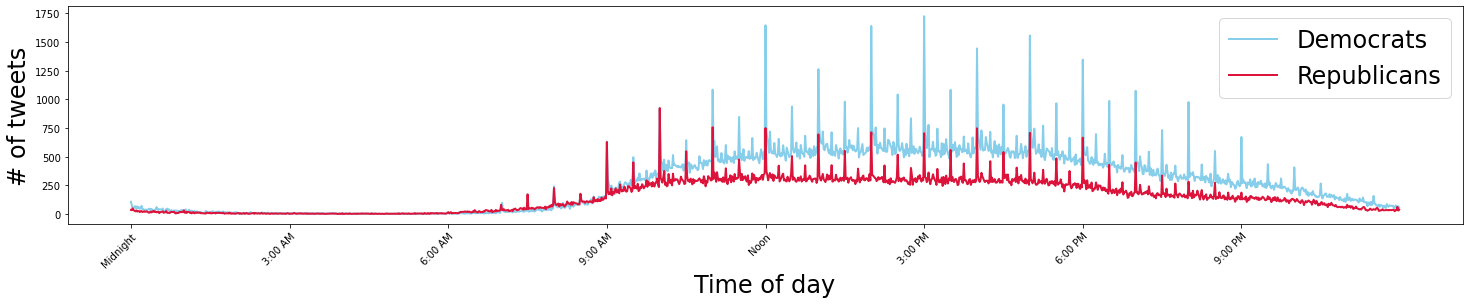

In [ ]:
#Create a figure with an appropriate size to view the data
#(arrived at through trial + error)
plt.figure(figsize=(25,4))

#Plot the number of Democrats' tweets
x1 = time_df[time_df.party == "D"].groupby('min').size()
plt.plot(x1, color="skyblue", label="Democrats", lw=2)

#Plot the number of Republicans' tweets
x2 = time_df[time_df.party == "R"].groupby('min').size()
plt.plot(x2, color="crimson", label="Republicans", lw=2)

#Make the tick marks along the x-axis more legible
plt.xticks([i*180 for i in range(8)],
           ["Midnight", "3:00 AM", "6:00 AM","9:00 AM",
            "Noon", "3:00 PM", "6:00 PM","9:00 PM"],
           rotation=45, rotation_mode='anchor',ha='right',va='top')

#Add a label to our x- and y-axes, respectively
plt.xlabel("Time of day", fontsize=24)
plt.ylabel("# of tweets", fontsize=24)

#Add a legend
plt.legend(fontsize=24)
#plt.savefig("Plot1.png")
plt.show()

I picked these colors because they correspond to the colors most associated with these two political parties, but when your plotting you should also consider the accesibility of your visualizations. Specifically, many of these plotting libraries have colorblind-friendly visualization options and/or greyscale options. At the very least, try to pick colors that have different brightnesses like the crimson and skyblue colors used in this graph. One way to check is to actually save your plot by un-commenting the penultimate line of code in the block above and then view it in grayscale.

It looks like in 2020 MoCs tended to tweet between 9:00 AM ad 9:00 PM, and it's apparent from this graph that in 2020 Democrats tweeted more than Republicans. To confirm that, we can also run this single line of code:

In [ ]:
Counter(time_df.party)

Counter({'D': 399361, 'R': 225649})

Which tells us that in our corpus, nearly 400k tweets were associated with a Democrat while less than 250k were associated with a Republican. Next, let's make a very similar plot that shows on what days MoCs of the two major parties published tweets.

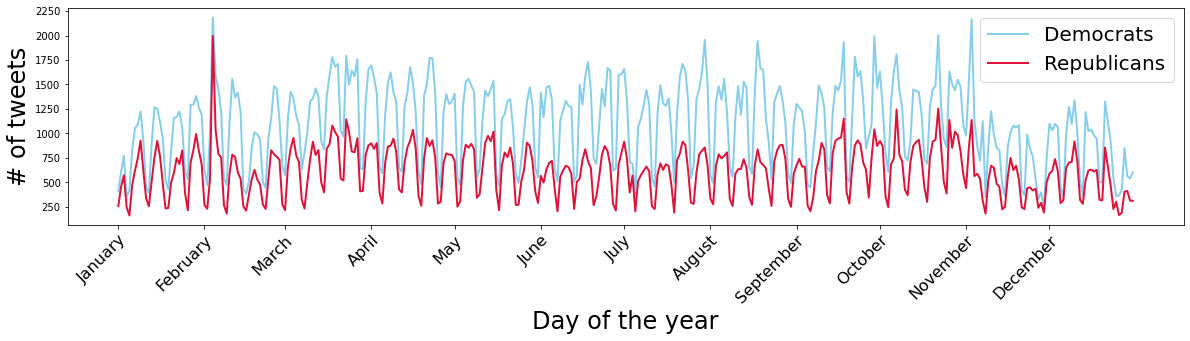

In [ ]:
#Create a figure with an appropriate size to view the data
plt.figure(figsize=(20,4))

#Plot the number of Democrats' tweets
plt.plot(time_df[time_df.party == "D"].groupby('day').size(),
         color="skyblue", label="Democrats", lw=2)

#Plot the number of Republicans' tweets
plt.plot(time_df[time_df.party == "R"].groupby('day').size(),
         color="crimson", label="Republicans", lw=2)

#Make the tick marks along the x-axis more legible
plt.xticks(['{}-01'.format(str(i+1).zfill(2)) for i in range(12)],
           ["January","February","March","April","May", "June",
            "July","August","September","October","November","December"],
           rotation=45, rotation_mode='anchor',ha='right',va='top',fontsize=16)

#Add a label to our x- and y-axis, respectively
plt.xlabel("Day of the year", fontsize=24)
plt.ylabel("# of tweets", fontsize=24)

#Add a legend
plt.legend(fontsize=20)

plt.show()

There's an interesting day in February where tweets are generally higher and Republicans tweeted about the same amount as Democrats. Any idea what that might be? To investigate, first let's identify what day that exactly is.

In [ ]:
#Look up the day with the highest number of total tweets
time_df.groupby('day').size().sort_values().tail(1)

#Can also do time_df.day.mode(), but won't return the number of tweets on that day

day
02-04    4177
dtype: int64

Most folks probably don't remember or know what happened on February 4th that might account for this abnormality. To figure it out, we'll go ahead and randomly sample some tweets that were published on that day and look at their raw text.

In [ ]:
#Set the random seed so that we all get the same results every time we run this
np.random.seed(8675309)

#Randomly sample 20 tweets published on Feb 4th
raw_tweet_df[raw_tweet_df.time.apply(lambda x: x.split("T")[0] == "2020-02-04")].sample(20).text.tolist()

['He is routinely and openly hostile to any legitimate Congressional oversight. \n\nHe has made clear his wanton corruption by soliciting a bribe from a foreign government for his personal political gain.',
 'RT @rawhidevelvet Y’ALL. Oh. Em. Gee. \nIf you are the new “brand ambassador” for @shinerbeer, raise your hand. 🙋🏻\u200d♀️ &lt;— that’s ME! Eeekkk! I’m so stinkin’ excited about this new partnership! I can’t wait to share some of the super fun events and idea we’ve been cooking up for y’all. Spoiler Alert ... http://pbs.twimg.com/media/EP9ytZcX0AAVUI5.jpg',
 'The #healthcare system is broken. A tax advantaged savings plan and transparent approach to pricing will set America on the right track. Read more about my solution here: https://www.washingtonexaminer.com/opinion/op-eds/my-plan-to-expand-hsas-and-healthcare-price-transparency. #PatientFairnessAct',
 'We are exactly one week from the #FITN primary. Our goal is to exceed expectations and surge on February 11th, by:\n\n- Contin

And if you read through these it will be apparent that many of these tweets were reactions to Donal Trump's 2020 state of the union address. Pretty cool that we were able to see that in such a simple descriptive analysis!

Lastly, we're going to look at how the frequency of certain words change over time in our corpus.

In [ ]:
def daily_word_freq(w,
                    title=None,
                    df=time_df,
                    text="text",
                    day="day",
                    prop=True):
  '''
  A function that plots the daily prevelance of a word or list of words.

  Assumes that time_df is a pandas dataframe in which text is the name of a column
  containing an iterable of strings and in which day is the name of a column
  containing a string encoding the date as MM-DD. Assumes that the first of
  each month is present in the day column.

  w should be either a string (to identify the frequency of a single word) or an
  iterable of strings (to identify the combined frequency of those words)

  If prop (short for proportion), then plot the proportion of tweets each day
  containing the word or at least one of the list of words. If not prop, then
  plot the raw frequencies.

  Optionally, pass a title to give to the plot.
  '''

  #Count the prevelance of the word or list of words in each tweet
  if type(w) == str:
    df['w'] = df[text].apply(lambda x: w in x)
  elif type(w) == list:
    df['w'] = df[text].apply(lambda x: any([i in x for i in w]))

  #Create a figure with an appropriate size to view the data
  plt.figure(figsize=(20,4))

  #Plot the daily frequencies
  if prop:
    plt.plot(df[['w',day]].groupby(day).mean(),lw=3)
  else:
    plt.plot(df[['w',day]].groupby(day).sum(), lw=3)

  #Make the ticks on the x-axis more legible
  plt.xticks(['{}-01'.format(str(i+1).zfill(2)) for i in range(12)],
           ["January","February","March","April","May", "June",
            "July","August","September","October","November","December"],
           rotation=45, rotation_mode='anchor',ha='right',va='top')

  #Add a label to the x-axis
  plt.xlabel("Day of the year", fontsize=24)

  #Add a label to the y-axis
  if prop:
    plt.ylabel("% of tweets", fontsize=16)
  else:
    plt.ylabel("# of tweets", fontsize=16)

  #Add a title to the plot
  plt.title(title, fontsize=32)

First, we'll see when and how often MoCs discussed coronavirus. As a proxy for this, we'll see when MoCs used either "pandemic", "coronavirus", or "covid".

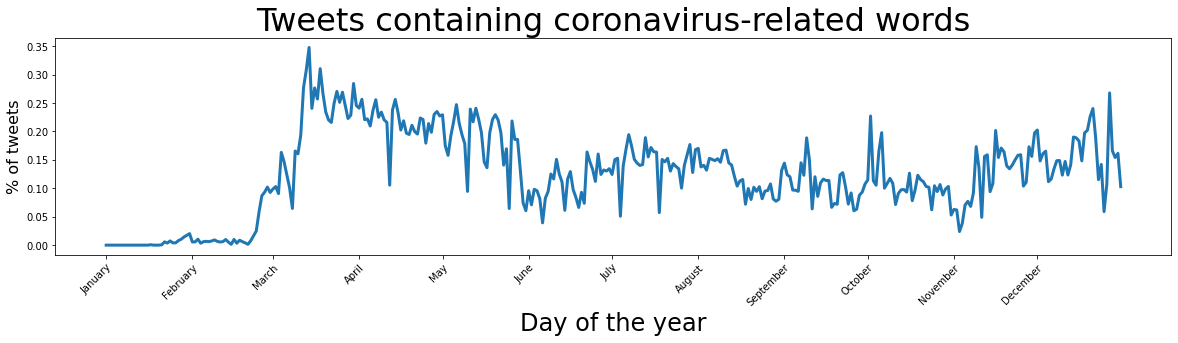

In [ ]:
#Define a list of words to examine and
words = ['pandemic','coronavirus','covid']

#Define a title for the graph
title = "Tweets containing coronavirus-related words"

#Generate the graph with our new function
daily_word_freq(words,title)

plt.show()

This function is set up so that you can also add other elements to the plot. For instance if you want to change the title or the tick marks on the x- or y-axis, you can put those commands after you call the function. This also means you can plot important reference points us `plt.axvline` or `plt.axhline`. See the below example...

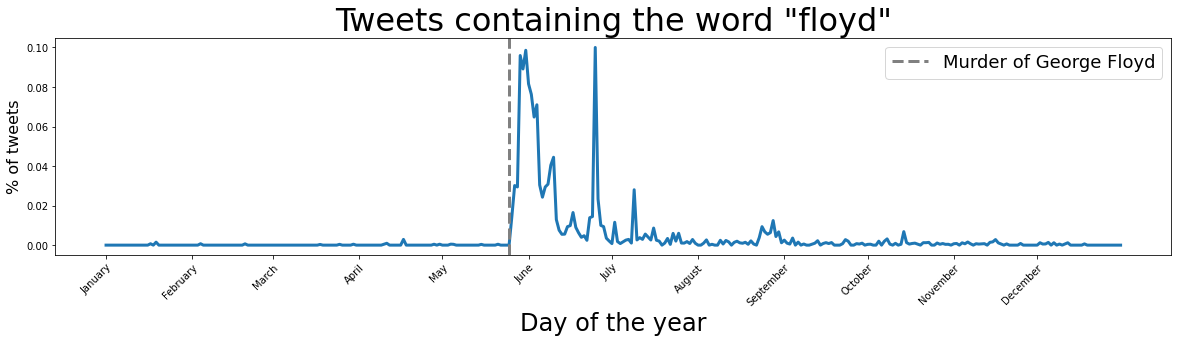

In [ ]:
#Plot the daily frequencies of the word "floyd"

daily_word_freq('floyd', title='Tweets containing the word "floyd"')

#Add a vertical line to indicate the date of George Floyd's murder
plt.axvline('05-25', label="Murder of George Floyd", ls="--",
            color="grey", lw=3)

#Add a legend
plt.legend(fontsize=18)
plt.show()

# Section V: Dictionary (or Closed-Vocabulary) Analysis

Now that we've gone over how to scrape data from the Twitter API, how to download data from the web, how to pre-process text data, and how to do some descriptive analyses and plot the results, we'll discuss how to test whether features of the text significantly vary along elements of the texts' meta-data.

Our first method is what is often referred to as "dictionary" analysis. The intuition for this method and other analyses of "unigram frequencies" is that word choice is a theoretically interesting characteristic. For instance, the degree to which someone uses "swear words" in their journal might tell you something about them. These methods assume that the usage of words, regardless the linguistic context in which they are used, provides a reliable signal that one can use for statistical analysis. If you make that assumption, the rest of the analysis follows pretty straight-forwardly: select the set of theoretically interesting words (words for which you assume prevelance of that word corresponds to your theoretical construct of interest), count how often they are used in each text, and then correlate that with meta-data of the text. I'll talk more analytically about dictionary analysis and analyses of unigram frequency during the talk associated with this tutorial (I'll be sure to add the link once it is available online).

Below I define a set of functions, culminating in the `dict_vec` function, that allow you to perform your own dictionary analyses with only a couple lines of code. In essence, these three functions allow you to define your own "dictionary" and then determine the prevelance of each category defined in that dictionary in a string or list you also pass to it.

In [ ]:
def regexify(s):
  #Helper function for dictify below
  if s[-1] == "*":
    return '(?<!\w){}\w*?[\s.]'.format(s[:-1])
  else:
    return '(?<!\w){}[\s.]'.format(s)

def dictify(d):
  '''
  Takes in a dictionary where keys are categories and the values are lists of
  words that indicate each category. Outputs a dictionary that can be used by
  dict_vec below. Helpful if you are not comfortable with regular expressions,
  but is limited by design. There is one key functionality built in: if a word
  ends in a "*", then the generated regular expression will look for words with
  any additional letters at the end of it (e.g. "eat*" captures "eat",
  "eating", "eats", etc.). The same does not hold for "*" at the beginning of a
  word.
  '''
  return {k: [regexify(w) for w in d[k]] for k in d}

def dict_vec(s, d, clean=clean_tweet):
  '''
  Takes in a string and a dictionary which is structured {C1: [W11, W21, ...],
                                                          C2: [W12, W22, ...]}
  Where Cx is the name of a category and Wxy is a regular expression which
  indicates a string 'more belongs' in category x and outputs a dictionary
  structured {C1: S1, C2: S2, ...} where Cx is the name of a category and
  Sx is how much the passed string 'belongs' in that category.
  '''

  #Create a receptacle for the results
  results = {k: 0 for k in d.keys()}

  #Start a counter for the total number of dictionary words
  results['_total_'] = 0

  if type(s) == str:
    s = clean(s)

  #Turn the tokenized list into a string (it works better for regular expressions)
  s = ' '.join(s)

  #For each category in the dictionary
  for k in d.keys():

      #Create a single regular expression that will capture any word in the category
      combined_re = "(" + ")|(".join(d[k]) + ")"

      #Count the number of times a word in this category appears in the text
      count = len(re.findall(combined_re,s+' '))

      #Add that count to the category count
      results[k] += count

      #Add that count to the total number of dictionary words
      results['_total_'] += count


  results['_len_'] = len(clean(s))

  return results

In [ ]:
#A list of words associated with politics
politic_words = ['politi*', 'congressional hearings', 'president*', 'democrat*', 'republican*']

#A list of words associated with food
food_words = ['tuna', 'pineapple', 'burger', 'din*', 'eat*']

#Create a dictionary
new_dict = {'politics': politic_words,
            'food': food_words}

#Pass this dictionary to the dictify function
new_dict = dictify(new_dict)

In [ ]:
dict_vec('The politicians at the very political congressional hearings are eating him alive', new_dict)

{'_len_': 6, '_total_': 4, 'food': 1, 'politics': 3}

## Do Republicans and Democrats use different moral language?

[Moral foundations theory](https://moralfoundations.org/) is a theory in moral psychology which posits that human morality is based on a set of basic principles (the exact number is up for debate, but folks in this theory currently believe there are five or six). Folks working in this theory have developed a "moral foundations dictionary", which they claim can be used in dictionary methods like what we're discussing to detect the evoking of these different moral principles.

Work using this theory has posited the American Democrats and Americans care differently about and evoke the different moral foundations differently. From this work, we could reasonably derive the following hypotheses:
* Moral words used by democratic MoCs will more often be related to fairness than those used by republican MoCs
* Moral words used by democratic MoCs will more often be related to harm than those used by republican MoCs
* Moral words used by democratic MoCs will less often be related to authority than those used by republican MoCs
* Moral words used by democratic MoCs will less often be related to ingroup loyalty than those used by republican MoCs
* Moral words used by democratic MoCs will less often be related to purity than those used by republican MoCs

The moral foundations theory is publicly available [here](https://moralfoundations.org/other-materials/). It was originally designed to be used with a proprietary program called [LIWC](http://liwc.wpengine.com/), which is a very commonly used software for dictionary analysis in psychology and sociology. During my time leading the student group for computational text analysis in the social sciences (CTASS), a group at Stanford, I slightly modified the moral foundations (MF) dictionary to be used with standard Python. Below we're going to download that modified version off of the [CTASS GitHub](https://github.com/ctass).

In [ ]:
'''
This function grabs a version of the moral foundations dictionary from the
Stanford CTASS GitHub which can be used with
the dict_vec function below
'''

mfd = requests.get('https://raw.githubusercontent.com/ctass/fall-workshop-2019/master/mfd.dict').json()
mfd

{'AuthorityVice': ['(?<!\\w)betray\\w*?[\\s.]',
  '(?<!\\w)treason\\w*?[\\s.]',
  '(?<!\\w)traitor\\w*?[\\s.]',
  '(?<!\\w)treacher\\w*?[\\s.]',
  '(?<!\\w)disloyal\\w*?[\\s.]',
  '(?<!\\w)apostasy[\\s.]',
  '(?<!\\w)apostate[\\s.]',
  '(?<!\\w)deserted[\\s.]',
  '(?<!\\w)deserter\\w*?[\\s.]',
  '(?<!\\w)deserting[\\s.]',
  '(?<!\\w)defian\\w*?[\\s.]',
  '(?<!\\w)rebel\\w*?[\\s.]',
  '(?<!\\w)dissent\\w*?[\\s.]',
  '(?<!\\w)subver\\w*?[\\s.]',
  '(?<!\\w)disrespect\\w*?[\\s.]',
  '(?<!\\w)disobe\\w*?[\\s.]',
  '(?<!\\w)sediti\\w*?[\\s.]',
  '(?<!\\w)agitat\\w*?[\\s.]',
  '(?<!\\w)insubordinat\\w*?[\\s.]',
  '(?<!\\w)illegal\\w*?[\\s.]',
  '(?<!\\w)lawless\\w*?[\\s.]',
  '(?<!\\w)insurgent[\\s.]',
  '(?<!\\w)mutinous[\\s.]',
  '(?<!\\w)defy\\w*?[\\s.]',
  '(?<!\\w)dissident[\\s.]',
  '(?<!\\w)unfaithful[\\s.]',
  '(?<!\\w)alienate[\\s.]',
  '(?<!\\w)defector[\\s.]',
  '(?<!\\w)heretic\\w*?[\\s.]',
  '(?<!\\w)nonconformist[\\s.]',
  '(?<!\\w)oppose[\\s.]',
  '(?<!\\w)protest[\\s.]',
  '(

In [ ]:
#List the different categories in the moral foundations dictionary
mfd.keys()

dict_keys(['HarmVirtue', 'HarmVice', 'FairnessVirtue', 'FairnessVice', 'IngroupVirtue', 'IngroupVice', 'AuthorityVirtue', 'AuthorityVice', 'PurityVirtue', 'PurityVice', 'MoralityGeneral'])

In [ ]:
dict_vec('This is an unjust test string. It is a very pure test string.',mfd)

{'AuthorityVice': 0,
 'AuthorityVirtue': 0,
 'FairnessVice': 1,
 'FairnessVirtue': 0,
 'HarmVice': 0,
 'HarmVirtue': 0,
 'IngroupVice': 0,
 'IngroupVirtue': 0,
 'MoralityGeneral': 0,
 'PurityVice': 0,
 'PurityVirtue': 1,
 '_len_': 6,
 '_total_': 2}

For testing our hypotheses (and for some of the analyses we'll do in the next section), we'll want to be working with MoC-level data instead of tweet-level data. The next few blocks of code will create a MoC-level dataframe by appending all of each MoC's tweets together into a single, long list.

When I ran these analyses on all of the data, it took a little longer than I would have hoped. So, for the purposes of this tutorial we'll actually make our MoC-level dataframe out of 50k randomly sampled tweets from our overall corpus so that things run more quickly. If you wanted to do this analysis on all of the data, you could just change the line `user_df = df[['name','party','text']].sample(50000)` to `user_df = df[['name','party','text']]`.


In [ ]:
#Set the random seed so we get the same answers every time
np.random.seed(8675309)

#Randomly sample 50k tweets for our new dataframe
user_df = df[['name','party','text']].sample(50000)

#Aggregate our new dataframe at the MoC level
user_df = user_df.groupby(['name','party']).sum().reset_index()
user_df

,name,party,text
0,Abby Finkenauer,D,"[tonight, we, held, tele-townhall, meeting, he..."
1,Abigail Spanberger,D,"[said, better, wear, mask, —, if, rep, local, ..."
2,Adam Kinzinger,R,"[brother, friend, thing, surrendering, constit..."
3,Adam Schiff,D,"[response, worst, economic, crisis, decades, t..."
4,Adam Smith,D,"[students, defrauded, predatory, for-profit, c..."
...,...,...,...
521,Warren Davidson,R,"[paycheck, protection, program, working, ohioa..."
522,Will Hurd,R,"[🚨, great, news, rural, hospitals, 🚨, hospital..."
523,Xochitl Torres Small,D,"[wishing, family, happy, easter, hope, loved, ..."
524,Yvette Clarke,D,"[45, wants, spend, $, 2, billion, useless, bor..."


The next step is to apply our `dict_vec` function to the MoC-level data set. This will, for each MoC, produce a dictionary outlining how many times they used the words in each of the moral foundations dictionary categories. Here we're also going to drop all MoCs from our data for whom we don't have at least one-thousand (non-stop word) words to observe.

**WARNING**: Even though we down-sampled our data, this cell takes awhile to run. It took me 4 minutes and 20 seconds. If you already have a specific dictionary in mind and know how you'd want to analyze it, you can probably rewrite these functions to make them run a lot faster.

In [ ]:
#Create a new column containing each MoC's frequencies of the MFD categories
user_df['moral_dict'] = user_df.text.apply(lambda x: dict_vec(x, mfd))

#Drop MoCs for whom we do not have sufficient data
user_df = user_df[user_df.moral_dict.apply(lambda x: x['_len_'] > 1000)]

user_df

,name,party,text,moral_dict
0,Abby Finkenauer,D,"[linn, our, 20th, county, #20in20, met, weekly...","{'HarmVirtue': 39, 'HarmVice': 33, 'FairnessVi..."
1,Abigail Spanberger,D,"[our, economy, cannot, reopen, without, safe, ...","{'HarmVirtue': 62, 'HarmVice': 30, 'FairnessVi..."
3,Adam Schiff,D,"[trump, knew, true, february, he, told, bob, w...","{'HarmVirtue': 34, 'HarmVice': 19, 'FairnessVi..."
4,Adam Smith,D,"[dod, ig, must, immediately, investigate, whet...","{'HarmVirtue': 34, 'HarmVice': 31, 'FairnessVi..."
6,Adriano Espaillat,D,"[he, dedication, life, public, service, played...","{'HarmVirtue': 61, 'HarmVice': 22, 'FairnessVi..."
...,...,...,...,...
518,Veronica Escobar,D,"[icymi, yesterday, house, representatives, pas...","{'HarmVirtue': 60, 'HarmVice': 50, 'FairnessVi..."
519,Vicente Gonzalez,D,"[hearty, congratulations, @iingwen, re-electio...","{'HarmVirtue': 25, 'HarmVice': 7, 'FairnessVir..."
522,Warren Davidson,R,"[#icymi, make, markets, work, ..., oth, ­, ers...","{'HarmVirtue': 28, 'HarmVice': 18, 'FairnessVi..."
524,Xochitl Torres Small,D,"[our, state, seeing, sharp, rise, positive, co...","{'HarmVirtue': 23, 'HarmVice': 8, 'FairnessVir..."


Now we calculate the actual measures we'll be using in our stastical tests. Here are a couple of reasonable approaches to this:
* Compare the counts of how many times a word in a category appears. In our example, for instance, this would be like asking e.g. "do democrats use more words related to harm than republicans?"
* Compare the proportion of all words that belong to a category (i.e. normalize the raw counts by the total number of words). In our example, for instance, this would be asking e.g. "when democrats publish tweets, are a higher proportion of those tweets' words related to harm than for republicans?"
* Compare the fraction of occuring words in the dictionary that belong to a specific category. In our example, for instance, this would be asking e.g. "when democrats use moral words in their tweets, are a higher proportion of those words related to harm than for republicans?"

Most of time folks use the second. In our example, it actually makes a little more sense (to me, at least) to use the third (though feel free to try the others!). Below we'll calculate this value for each category of the MF dictionary for each MoC.

In [ ]:
d = user_df.moral_dict

user_df['fair_prop'] = d.apply(lambda x: (x['FairnessVice'] + x['FairnessVirtue'])/x['_total_'])
user_df['harm_prop'] = d.apply(lambda x: (x['HarmVice'] + x['HarmVirtue'])/x['_total_'])
user_df['loyal_prop'] = d.apply(lambda x: (x['IngroupVice'] + x['IngroupVirtue'])/x['_total_'])
user_df['auth_prop'] = d.apply(lambda x: (x['AuthorityVice'] + x['AuthorityVirtue'])/x['_total_'])
user_df['pur_prop'] = d.apply(lambda x: (x['PurityVice'] + x['PurityVirtue'])/x['_total_'])

To test the differences in these proportions across our two groups, we'll use the [Mann-Whitney U Test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) aka the Wilcoxon rank-sum test. We'll use this test because it's nonparametric (we don't need to make any assumptions about the shape of the distributions). The null hypothesis here is that a randomly selected value from one group is just as likely to be higher than a randomly selected value from the other group as the other way around. A p-value of less than 0.05 will suggest that this is unlikely, and, assuming the means of two groups are ordered as we expect, will provide support for our respective hypotheses.

Instead of re-writing the code to perform this test and graph our results for each MFD category, I'm going to write a function to do this for any given variable.

In [ ]:
def u_test_by_party(x, var_lab,
                    df = user_df):

  #Create a plot with KDEs of the two groups' values
  sb.kdeplot(data=df, x=x, hue="party", fill=True,
           lw=2, palette='colorblind', alpha=0.05)

  #Add a legend
  plt.legend(labels=['Republican','Democrat'], fontsize=14)

  #Add a label to the x-axis
  plt.xlabel("% MoC's moral words that relate to {}".format(var_lab))
  plt.show()

  #Return the results of the statistical test
  return ranksums(df[df.party == "D"][x], df[df.party == "R"][x])

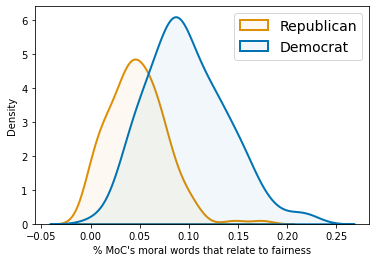

RanksumsResult(statistic=11.208159466617278, pvalue=3.7184509986323856e-29)

In [ ]:
moral_language_test('fair_prop', 'fairness')

Note that the *p*-values use scientific notation, so 3.7184...e-29 << 0.05. See the code below.

In [ ]:
#Print thirty-five digits of this number expressed in scientific notation
'{:.35f}'.format(3.7184509986323856e-29)

'0.00000000000000000000000000003718451'

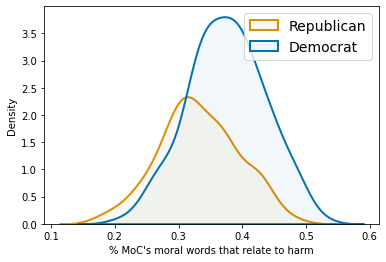

RanksumsResult(statistic=6.2014863218007195, pvalue=5.593238228078458e-10)

In [ ]:
moral_language_test('harm_prop', 'harm')

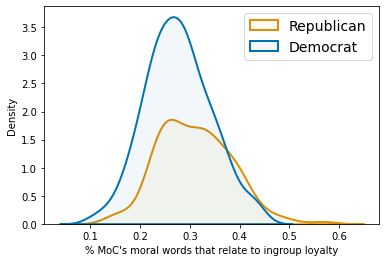

RanksumsResult(statistic=-4.170352828548481, pvalue=3.0412840924968958e-05)

In [ ]:
moral_language_test('loyal_prop', 'ingroup loyalty')

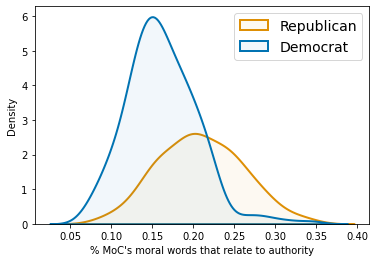

RanksumsResult(statistic=-8.576440389518725, pvalue=9.785434940652561e-18)

In [ ]:
moral_language_test('auth_prop', 'authority')

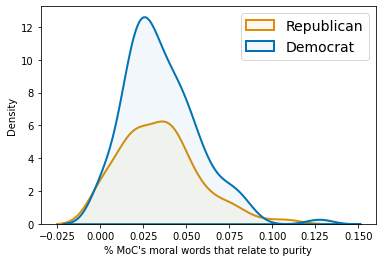

RanksumsResult(statistic=0.6367772232637647, pvalue=0.5242699642067735)

In [ ]:
moral_language_test('pur_prop', 'purity')

So out of our five hypotheses, four are supported by the analysis here! To be clear, to do this properly one should use all the available tweets in our corpus; we're reducing the precision (and therefore probably the power) of the analysis in taking a subsample.

# Section VI: Open-Vocabulary Analysis (Differential Language Analysis; DLA)

[DLA](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791) is a method to inductively assess systematic differences in unigram frequencies. Above, we tested specific hypotheses about differences in language use derived from theory. This method, instead, allows us to explore differences in language that may or may not exist along some pre-specified axis of variation.

Imagine if we were to analyze linguistic differences between MoCs' campaign accounts and their office accounts. If we already had some ideas about what these differences might be (e.g. campaign accounts might use more formal language, office accounts might use more words related to congress), we could measure them like we did in the above section and deploy the appropriate statistical test. On the other hand, we might be interested in *whether* this language differs, and if so how. For addressing that question we might prefer an exploratory analysis like DLA.

Intuitively, DLA performs a seperate statistical test for every word in a vocabulary (or whatever set of language feature you're interested in) to assess whether its use is associated with text meta-data after [correcting for multiple testing](https://en.wikipedia.org/wiki/Multiple_comparisons_problem#Multiple_testing_correction). It has been likened to genome-wide associations studies ([GWAS](https://en.wikipedia.org/wiki/Genome-wide_association_study)), which do a similar procedure to explore how nucleotide arrangements are associated with phenotypes and diseases. The basic idea is that with enough quantitative data, we can glean knowledge from approaching it without theoretical priors as long as we do so in a principled way.

Now, the folks who developed DLA actually have their own "end to end human text analysis package" called [DLATK](https://dlatk.wwbp.org/), and if you're interested in learning more about DLA I'd recommend you start there. We're going to instead code our own version of DLA from scratch to get a better understanding of how it works.

The first step of DLA is to identify what is the axis of variation you're interested in (e.g. if a tweet originated from a campaign account or an office account). You'll ultimately be trying to identify language features that are predictive of this difference. Here we're going to look at the political party affiliation of the MoC associated with each tweet.

Next we need to decide on our set of linguistic features. When analyzing unigram frequencies using DLA, this is typically a vocabulary of the *k* most frequent words in our corpus (excluding stop words), where *k* is a parameter you can set. The higher the value of *k*, the more words you test. The value of *k* also effects the burden-of-proof for any particular association: the higher the value of *k*, the higher the bar is for finding a significant association. For our purposes, I'll just pick 500 so that the code doesn't take very long to run.

So, to establish our vocabulary, we first have to iterate over the entire corpus and count how many times each word appears.

In [ ]:
counts = Counter()
for t in tweet_df.text:
  counts.update(t)

Then, we'll select out the top *k* words in terms of their frequency in the corpus.

In [ ]:
vocab_size = 500
vocab = sorted(counts.keys(), key=lambda w: counts[w], reverse=True)[:vocab_size]
vocab

['our',
 'we',
 'today',
 'need',
 'trump',
 'health',
 'people',
 'help',
 'us',
 'must',
 'act',
 'president',
 'if',
 'he',
 'americans',
 'work',
 'new',
 'get',
 'time',
 'covid',
 'american',
 'support',
 '—',
 '$',
 'house',
 'make',
 '️',
 'care',
 'thank',
 'vote',
 'pandemic',
 'one',
 '#covid19',
 'day',
 'country',
 '19',
 'families',
 'congress',
 'senate',
 'bill',
 'workers',
 'great',
 'state',
 '@realdonaldtrump',
 'like',
 'keep',
 'businesses',
 'communities',
 'working',
 'would',
 'continue',
 'small',
 'coronavirus',
 'community',
 'crisis',
 'every',
 'relief',
 'protect',
 'first',
 'proud',
 'public',
 'america',
 'many',
 'right',
 'federal',
 'join',
 'fight',
 'years',
 'take',
 'last',
 'year',
 'back',
 'across',
 'nation',
 'week',
 'ensure',
 'know',
 'national',
 'safe',
 'lives',
 'u',
 'election',
 'important',
 'see',
 'funding',
 'law',
 'women',
 'democrats',
 '...',
 'together',
 'local',
 'let',
 'family',
 'still',
 "i'm",
 'administration',
 'j

Now that we've identified our axis of variation (political party) and built our vocabulary, the last thing we need to do is pick our unit of analysis and the appropriate statistical test. We'll be looking at two different ways we might analyze this data.

The first, which is more straight forward and quicker to compute, is analyzing at the user level. Specifically, for each MoC we'll measure their political party affiliation and, for each word in the vocabulary *w*, what proportion of their language in our corpus is the word *w*, and then test whether these two values are associated using a [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). After we've collected the *p*-values associated with each word in the vocabulary, we'll correct all of them for multiple testing and then examine the words that remain significantly predictive.

The second analysis will instead be at the tweet level. Specifically, we'll assess whether the party of the MoC associated with a tweet is significantly associated with the presence of each word in the vocabulary. For this analysis we'll need to [cluster our standard errors](https://en.wikipedia.org/wiki/Clustered_standard_errors) at the individual level. You could reasonably do more with this (e.g. a random effects model), but this is as far as we'll take this exercise.

For both analyses we'll end up using a logistic regression where party is predicted by a measure of word prevelance. Below I define a function that will let us do this in a single line of code and optionally produce a simple graph of the results.

In [ ]:
def wf_logit(w, txt, Y,
             graph=False,
             group_labels=None,
             summary=False,
             prop=True,
             robust_se=False,
             cluster_group=None):

  '''
  Function that takes in a string w, an iterable of iterables txt, and a binary
  outcome vector Y, and tests whether prevelance of w in txt is correlated with
  Y using a logistic regression.

  If graph, then produces a so-called "dynamite" plot, or a bar graph displaying
  group means with bootstrapped standard error bars. If group_labels is passed,
  will use these as labels for the x-axis tick marks.

  If prop, use the proportion of each entry of txt that is equal to w. If prop
  is False, then instead use whether w in contained in each entry of txt at all.

  If robust_se is set to True, then use HC3 standard errors (standard errors
  that are robust to heteroskedasticity) when performing the logistic regression.

  If cluster group is a list of group assignmnents (will not work if a pandas
  series!) equal in size to the length of txt, then use standard errors
  clustered on that group assignment.

  If summary is True, returns a summary table of the logistic regression. If
  summary is False, returns a dictionary with three entries:
  {"w": identifcal to the w that is passed (string),
   "p": the p-value that results from the logistic regression (float),
   "b": the unexponentiated coefficient associated with the logistic regression (float)}
  '''

  if prop:
    #For each row in txt, get the proportion of w
    x = txt.apply(lambda t: t.count(w)/len(t))
  else:
    #For each row in txt, get whether w is in the row
    x = txt.apply(lambda t: int(w in t))

  if graph:
    #Create a barplot of group means with bootstrapped SEs
    sb.barplot(x=Y, y=x, n_boot=1000)

    #Add group labels if they were passed
    if group_labels:
        plt.xticks([0,1], labels=group_labels)

    #Label the y axis
    plt.ylabel('P("{}")'.format(w))
    plt.show()

  #Add a constant term
  x = sm.add_constant(x)

  if robust_se:
    cov_type="HC3"
  elif cluster_group:
    cov_type="cluster"
  else:
    cov_type="nonrobust"

  #If using clustered standard errors, fit the appropriate model
  if cov_type == "cluster":
    model = sm.Logit(Y, x).fit(cov_type=cov_type,
                                cov_kwds={'groups': cluster_group},
                                disp=0)

  #If using HC3 or vanilla standard erros, fit the appropriate model
  else:
    model = sm.Logit(Y, x).fit(cov_type=cov_type, disp=0)

  if not summary:
    #Extract the appropriate p-value and beta coefficient
    p = model.pvalues[1]
    b = model.params[1]

    return {'w': w, 'b': b, 'p': p}

  else:
    return model.summary()

## DLA at the user level

First, to get a better sense of how this analysis works, let's just imagine our vocabulary only had one word in it: "black". If this were the case, the analysis would consist of only the following block of code:

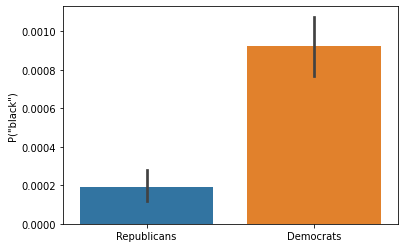

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  526
Model:                          Logit   Df Residuals:                      524
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Mar 2022   Pseudo R-squ.:                  0.1106
Time:                        00:38:54   Log-Likelihood:                -323.29
converged:                       True   LL-Null:                       -363.50
Covariance Type:            nonrobust   LLR p-value:                 3.033e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3609      0.107     -3.380      0.001      -0.570      -0.152
text        1176.8482    181.647      6.479      0.000     820.826    1532.870
==============================================================================
"""

In [ ]:
#Define a vector of party identification for MoCs
Y = [{'R': 0, 'D': 1}[p] for p in user_df.party]

#Test whether using the word 'black' more often is associated with being a Democrat
wf_logit('black', user_df.text, Y,
         graph=True,
         summary=True,
         group_labels=("Republicans","Democrats"))

From this analysis, we see that Democrats use the word "black" more often than do Republicans, and we can be very confident that this association isn't due to random variation we might reasonably expect. The idea with DLA is to repeat this same analysis for every word in our vocabulary (yeah, all 500 of them), and then look at which words are highly predictive of our outcome variable.

**WARNING**: This cell took me 55 seconds to run.

In [ ]:
#Define a vector of MoC party identifications
Y = [{'R': 0, 'D': 1}[p] for p in user_df.party]

#Run the DLA
results = [wf_logit(w, user_df.text, Y) for w in vocab]

#Compile results into a pandas DataFrame
results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,w,b,p
0,our,-7.125863,5.316127e-01
1,we,106.971745,8.794863e-10
2,today,3.898399,8.794361e-01
3,need,357.115750,1.778746e-14
4,trump,318.276452,1.113266e-14
...,...,...,...
495,follow,37.329251,6.611136e-01
496,ones,678.940074,9.000618e-04
497,loans,-379.192699,1.020005e-02
498,department,-18.934287,8.965551e-01


To reduce the risk of false discovery, we'll correct the *p*-values from each individual regression for multiple testing. There are several reasonable corrections one could do; here we'll use [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) because of its conceptual simplicity, though it's a conservative correction and leads to lowering the power of your analysis (see [here](https://en.wikipedia.org/wiki/Family-wise_error_rate#Controlling_procedures) and [here](https://en.wikipedia.org/wiki/False_discovery_rate#Controlling_procedures) for alternatives). After that we'll look just at the words for which there is still a very significant difference between Democrats and Republicans.

In [ ]:
#Correct the p-values (Bonferroni)
results_df['p'] = results_df.p * vocab_size

#Drop results where the corrected p-value is too large
results_df = results_df[results_df.p <= 0.001]

In [ ]:
len(results_df)

60

In [ ]:
#Show the words significantly predictive of being a Republican
results_df[results_df.b < 0].sort_values('b').reset_index().drop('index',axis="columns")

,w,b,p
0,pelosi,-3206.541223,5.788961e-11
1,china,-2125.821739,1.029175e-12
2,freedom,-1635.702768,7.286001e-09
3,enforcement,-1219.858782,8.144950e-05
4,party,-1152.653174,2.433780e-04
5,strong,-1057.984767,1.098944e-04
6,impeachment,-1032.638662,5.662556e-04
7,morning,-1002.504211,1.244786e-05
8,protection,-984.420518,3.944116e-04
9,discuss,-973.039435,1.704640e-05


In [ ]:
#Show the 20 words most predictive of being a Democrat
results_df[results_df.b > 0].sort_values('b', ascending=False).head(20).reset_index().drop('index',axis="columns")

,w,b,p
0,affordable,3396.034989,4.099750e-10
1,protections,3317.069826,2.918007e-09
2,climate,2797.872292,7.500805e-07
3,conditions,2372.374818,1.860640e-05
4,mask,2348.563616,3.526990e-08
5,democracy,2163.245977,1.494594e-09
6,mail,2158.894869,8.851214e-09
7,housing,2047.498858,5.879385e-05
8,cases,1925.525560,1.021473e-07
9,black,1893.881472,5.474847e-08


Interesting results! Notice that while "@realdonaldtrump" is used more by Republicans, "trump" is used more by Democrats. If we wanted to continue on with this analysis, next we'd want see in what contexts MoCs were using these different words. Also, recall that our `user_df` also only contains a small sample of our entire corpus, so we'd want to repeat this analysis with all of the Twitter data we have). Finally, we'd also want to repeat this analysis with a larger vocabulary.

## DLA at the tweet level

Like before, let's imagine our vocabulary only had a single word: this time "jobs".

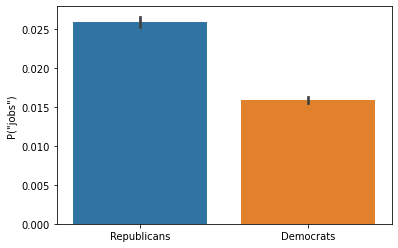

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               622162
Model:                          Logit   Df Residuals:                   622160
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Mar 2022   Pseudo R-squ.:               0.0008885
Time:                        00:44:24   Log-Likelihood:            -4.0679e+05
converged:                       True   LL-Null:                   -4.0715e+05
Covariance Type:              cluster   LLR p-value:                2.275e-159
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5780      0.119      4.864      0.000       0.345       0.811
text          -0.4978      0.071     -7.034      0.000      -0.636      -0.359
==============================================================================
"""

In [ ]:
#Define a vector of party identifications for each tweet
Y = [{'R': 0, 'D': 1}[p] for p in df.party]

'''
Test whether containing the word "jobs" is associated with a tweet being
published by a Democrat, clustering standard errors at the MoC level
'''
wf_logit('jobs', df.text, Y,
         graph=True,
         summary=True,
         group_labels=("Republicans","Democrats"),
         prop=False,
         cluster_group=df.name.tolist())

This analysis tells us that if you see a tweet and it contains the word "jobs", it's much more likely to be produced by a Republican. As before, DLA will involve repeating this analysis on every word in our vocabulary we defined earlier.

In order to speed up our DLA a little bit, we're going to use the `multiprocessing` library. This allows us to parallelize our code, or divide up the work among the machine's multiple CPUs. The first step to this is to find out how many CPUs you have available to work with (if you don't already know the answer), as this will determine how much you can split up your code.

In [ ]:
n_cpu = mp.cpu_count()
n_cpu

2

Unfortunately Google only gives us two CPUs to work with (unless you pay for Colab Pro), but we'll take it!

To efficiently use the `multiprocessing` library it's easiest to define (a) an iterable (e.g. a list) of all the parameter values you want to loop over (for us, all the words in our vocabulary) and (b) a function that takes in a single parameter and spits out the results you want for that parameter value. (a) is already defined as `vocab`. I define (b) below.

In [ ]:
#Define a parallelizing-friendly version of our wf_logit function
def DLA_iter(w):
  return wf_logit(w, df.text, Y, prop=False, cluster_group=df.name.tolist())

And now we'll do our DLA analysis like before!

**WARNING**: this cell takes the longest to run out of any in the tutorial. It took me 19 minutes and 45 seconds.

In [ ]:
#Define a vector of party identifications for each tweet
Y = [{'R': 0, 'D': 1}[p] for p in df.party]

#Run the DLA analysis
with mp.Pool(n_cpu) as pool:
  results = pool.map_async(DLA_iter, vocab).get()

#Compile the results into a pandas DataFrame
results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,w,b,p
0,our,0.147326,1.210958e-02
1,we,0.381531,2.876725e-20
2,today,0.158987,4.918295e-04
3,need,0.589985,2.167234e-34
4,trump,1.175721,9.488737e-33
...,...,...,...
495,follow,0.201252,6.040932e-04
496,ones,0.360015,2.681242e-07
497,loans,-0.381423,1.588048e-05
498,department,0.067224,3.309878e-01


In [ ]:
#Correct the p-values for each regression for multiple testing (Bonferroni)
results_df['p'] = results_df.p * vocab_size

#Drop the results with corrected p-values that are too high
results_df = results_df[results_df.p < 0.001]

In [ ]:
len(results_df)

176

In [ ]:
#Show the 20 words most predictive of being a tweet produced by a Republican
results_df.sort_values('b').head(20)

,w,b,p
435,pelosi,-2.422094,5.053515e-83
213,china,-2.079085,6.694100e-42
295,🇸,-1.672624,1.695494e-12
290,🇺,-1.666395,1.359285e-12
43,@realdonaldtrump,-1.228486,4.857912e-05
384,farmers,-1.096320,2.139688e-05
414,freedom,-1.077859,5.146987e-35
87,democrats,-0.990174,2.184230e-17
464,impeachment,-0.964963,3.438163e-10
41,great,-0.849311,2.445255e-55


In [ ]:
#Show the 20 words most predictive of being a tweet produced by a Democrat
results_df.sort_values('b').tail(20)

,w,b,p
5,health,0.879861,1.593444e-38
232,benefits,0.887010,4.429028e-25
128,pass,0.887612,2.344645e-33
267,ballot,0.959331,1.554723e-23
54,crisis,0.979614,4.208866e-31
467,insurance,1.009548,7.473316e-20
186,change,1.065738,2.896060e-63
4,trump,1.175824,4.453602e-30
472,housing,1.258903,3.167727e-19
299,@joebiden,1.272495,1.996827e-06


# Conclusions and Next Steps

I hope you all enjoyed this tutorial and learned something helpful from it! Feel free to reach out to me through my [personal website](https://sites.google.com/view/austin-van-loon) if you have any questions about this tutorial.

I want to thank Nick Sherefkin, Jan Gerrit Voelkel, and Elisa Kim for helping me proofread and edit this notebook.

Social science is going to continue to incorporate automated text analysis, and I've only just touched the very tip of the iceberg in this tutorial. If you want to continue to learn more about text analysis, I'll point you to a couple of resources here.
* The [GitHub](https://github.com/ctass) page for CTASS (a student organization I lead for awhile and have been a member of for longer), in my clearly biased opinion, has some fantastic resources. Specifically, I'd recommend the slides from our Fall 2019 session ["From Theory to Measurement"](https://github.com/ctass/sessions-2019/blob/master/03_from_theory_to_measurement.pdf), in which Klint Kanopka and I try to think analytically about how to use human-generated text as data for testing scientific hypotheses and think about text from a measurement perspective. I'd also recommend our 2019 sessions on [word embeddings](https://github.com/ctass/sessions-2019/blob/master/Word%20Embeddings%20CTASS%201_17.pdf) and topic models ([slides](https://github.com/ctass/sessions-2019/blob/master/2_7%20Topic%20Models%20Slides.pdf); [audio](https://github.com/ctass/sessions-2019/blob/master/2_7%20Topic%20Models%20Audio.m4a)).
* There are a bunch of amazing social scientists working out how to use text analysis for social science and producing some truly stellar scientific work in the process. Check out e.g. [Gentzkow et al (2019)](https://web.stanford.edu/~gentzkow/research/text-as-data.pdf); [Egami et al (2018)](https://arxiv.org/abs/1802.02163); [Nelson (2020)](https://journals.sagepub.com/doi/full/10.1177/0049124117729703); and [Kozlowski et al (2019)](https://journals.sagepub.com/doi/full/10.1177/0003122419877135).
* Try to find a community of other folks interested in using text analysis for social science near you! Share recent papers you find interesting that use the methods, talk about new methods as they become published, and invite speakers from all over! For SICSS participants, those in your "class" and beyond who might also be interested in text analysis are great people to do this with as well.

Enjoy the rest of the SICSS festival!